# Regularization

Fit a regression with some limitations on the coefficients making it somewhat resistent to overfitting

## Example 1. Regularization with artifical data

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import linear_model
import matplotlib.pylab as plt
import math
import seaborn as sbn
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.cross_validation import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import r2_score

/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#generate random data repeating regressors with minor fluctuations
M = 20
np.random.seed(1)

X = pd.DataFrame(np.random.randn(3*M,3))
Y = X.sum(axis = 1) + np.random.randn(3*M) #add a random target variable as a sum of three of the features and some noise
data = pd.concat([Y,X]+[X+0.01*np.random.randn(3*M,3) for i in range(4)], axis = 1)  # concatenate Y and X
data.columns = ['Y'] + ['x%d'%(i+1) for i in range(data.shape[1]-1)]         # rename the columns
dataTrain=data.iloc[:M,:]
dataTest=data.iloc[M:2*M,:]
dataValid=data.iloc[2*M:,:]

In [3]:
dataTrain.head()

,Y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15
0,-0.788142,1.624345,-0.611756,-0.528172,1.619363,-0.614866,-0.528191,1.622058,-0.595623,-0.531920,1.613616,-0.606805,-0.537692,1.631123,-0.622822,-0.531764
1,-2.195552,-1.072969,0.865408,-2.301539,-1.086935,0.856794,-2.294792,-1.080468,0.885954,-2.301005,-1.078150,0.850794,-2.306702,-1.067915,0.877587,-2.320946
2,1.805829,1.744812,-0.761207,0.319039,1.750997,-0.765639,0.337144,1.740020,-0.757705,0.319211,1.748323,-0.761895,0.305561,1.736750,-0.760716,0.313078
3,0.445823,-0.249370,1.462108,-2.060141,-0.262428,1.458658,-2.062449,-0.253662,1.474193,-2.048984,-0.234663,1.465480,-2.050060,-0.240754,1.441244,-2.056523
4,0.316851,-0.322417,-0.384054,1.133769,-0.350348,-0.364679,1.137433,-0.314009,-0.385083,1.145238,-0.314565,-0.390703,1.114319,-0.318158,-0.383564,1.144792


In [4]:
#perform a regression of the target variable against those three features we used to compute it
lm = smf.ols(formula = 'Y ~ x1+x2+x3', data = dataTrain).fit()
OLS_coef=lm.params
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     17.79
Date:                Wed, 30 Oct 2019   Prob (F-statistic):           2.38e-05
Time:                        17:48:02   Log-Likelihood:                -23.431
No. Observations:                  20   AIC:                             54.86
Df Residuals:                      16   BIC:                             58.84
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3465      0.197      1.757      0.0

R2 is somewhat high and the coefficient estimates are relatively close to the original ones we used - confidence intervals include 1; some deviations might be attributed to adding substantial noise to the target variable

In [5]:
'+'.join(dataTrain.columns[1:])

'x1+x2+x3+x4+x5+x6+x7+x8+x9+x10+x11+x12+x13+x14+x15'

Can we do better if we add other features? Although we know they are random and target variable has little to do with them...

In [6]:
lm2 = smf.ols(formula = 'Y ~ '+ '+'.join(dataTrain.columns[1:]), data = dataTrain).fit()
OLS_coef=lm2.params
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     3.715
Date:                Wed, 30 Oct 2019   Prob (F-statistic):              0.107
Time:                        17:48:02   Log-Likelihood:                -11.065
No. Observations:                  20   AIC:                             54.13
Df Residuals:                       4   BIC:                             70.06
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1937      0.608      0.318      0.7

R2 increased, but neither p-value nor coefficient estimates make much sense now.

Perfect case of multicollinearity and likely overfitting!

In [7]:
from sklearn.metrics import r2_score

In [8]:
#indeed the test R2 is negative this way
r2_score(dataTest.Y,lm2.predict(dataTest))

-0.892708496099802

How can we see from the regression itself that smth is wrong? Let's look at the coefficients having pretty hight magnitude compared to the original scale of the data

In [9]:
lm2.params

Intercept      0.193676
x1            -9.263060
x2           -32.409580
x3          -134.625216
x4           -11.160992
x5           -21.131152
x6           102.037978
x7           -25.407631
x8             4.826498
x9           -40.708135
x10           12.981378
x11           64.225496
x12           36.458027
x13           33.259082
x14          -14.292609
x15           37.977691
dtype: float64

# Idea of regularization

When fitting a linear regression with multiple features $x=(x^1,x^2,...,x^n)$ 
$$
y\sim w^T x
$$
the model might become complex and susceptible to overfitting. Complexity often comes with coefficients $w$ growing large in absolute values.

One way to reduce complexity is to penalize regression for the magnitude of the coefficients $w=(w^1,w^2,...,w^n)$, which can be measured by
$$
||w||_1=\sum\limits_j |w^j|
$$
or by 
$$
||w||_2^2=\sum\limits_j (w^j)^2
$$
So instead of simply minimizing 
$$
RSS(w)=\sum\limits_j (y_j-w^T x_j)^2
$$
where $x_j, y_j$ are observations for regressors and output variable, we minimize
$$
RSS(w)+\lambda ||w||_2^2=RSS(w)+\lambda \sum\limits_j (w^j)^2\to\min\hspace{10ex}(Ridge)
$$
or
$$
RSS(w)+\lambda ||w||_1=RSS(w)+\lambda \sum\limits_j \left|w^j\right|\to\min\hspace{10ex}(Lasso)
$$

The first model is known as Ridge, the second - as Lasso (least absolute shrinkage and selection operator) regularized regression.

Both Ridge and Lasso could be shown to be equivalent to a constrained minimization of $RSS$:

$$
RSS(w)\to min, \ ||w||_p\leq \alpha,
$$

with $p=1,2$ respectively, although analytic relation between constants $\alpha$ and $\lambda$ is somewhat nontrivial. In practice however the choice of $\lambda$ or $\alpha$ is usually empirical anyway, so both regularized or constrained forms of the optimization problem are equally applicable.

Optimization problems (Ridge) and (Lasso) tend to minimize $RSS$ at the same time penalizing the regression for having $||w||$ too large (regularization) which often leads to the model complexity through multiple regressors with large coefficients canceling effect of each other. So in a sense Lasso and Ridge are trying to avoid this situation, looking for relatively simple "regular" models with best possible fit. 

** NOTICE ** As the order of magnitude of $w^j$ is directly related to the scale of the regressors, it is practical to rescale them (e.g. by standardizing) to make sure the $w^j$ are comparable in scale. Otherwise penalization terms directly mixing components $w^j$ of different, sometimes incomparable, scale do not make too much sense.

From Bayesian standpoint (for those familiar with Bayesian inference) Lasso and Ridge simply perform the regression with the prior belief that all the components of the $w$ are limited through the fixed variance of the priors. Such a belief affects the final outcome of the model making solutions with large $||w||$ to be particularly unlikely.

This helps Ridge and Lasso to fight overfitting also dealing with multicollinearity of regressors to some extent, preventing from learning noise through particularly complex "unnatural" combinations of the regressors.

Ridge regression admits solution in the closed form (consider partial derivatives of the objective function with respect to $w_j$):

$$
\hat{w}=(X^T X+\lambda I)^{-1}X^T Y, \hspace{5ex}(Ridge\ solution)
$$

where $I$ is the identity $n\times n$ matrix, while $n$ being the number of regressors. The formulae (Ridge solution) shows that the Ridge regression can in theory deal with the case of multicollinearity, when the matrix $X^T X$ is singular and OLS estimate does not exist.

Lasso does not admit solution in the closed form and requires numerical methods (like subgradient methods) to be fit. 
Lasso however has an advantage of being often able to completely eliminate impact of certain irrelevant regressors setting the corresponding slope coefficients to zero.  

### Validation and cross-validation

A good way to evaluate the model is to use a test set separate from the training sample to estimate the model performance. Additionally if the model depends on the certain parameters (like $\alpha,\lambda$ for Lasso/Ridge) which are not supposed to be fit during the training phase, a separate validation sample could be used for the selection of model parameters (we pick up those which optimize model performance over the validation set). Usually test and validation sets are got as subsamples (often random) of the available dataset, while the remaining data is used as the training sample. 

But often the available dataset is small enough, so splitting into into even smaller traning, validation and test sets could have negative impact on the model training leading to noisy and unreliable models. In such cases cross-validation is often applied, performing not one but several random splits of the sample with further averaging of the model performance scores. 

## Choice of $\lambda$ or $\alpha$. Model validation.

In both - constrained and regularized forms - the parameter $\alpha$ or $\lambda$ of Lasso/Ridge regression is somewhat arbitrary and can take any value from $0$ to $+\infty$. Small values of $\lambda$ or high values of $\alpha$ lead to the result close to OLS (identical to it is $\lambda=0$ or $\alpha=+\infty$), while large $\lambda$ or small $\alpha$ tend to overemphasize the impact of regularization over the fit itself. There is no single best way of choosing the value of the regularization parameter - what is usually suggested is to fit it by evaluating the model for different values of the parameter over the separate validation set and picking up the value for which the validation performance is the best one. As for the performance metric one can use RSS or, equivalently, R2.

In [10]:
#try Ridge with an arbitrary regularization parameter alpha=1
Ridge=linear_model.Ridge(fit_intercept=True, alpha=1)
Ridge.fit(dataTrain.iloc[:,1:],dataTrain.Y)
# In sample:
YPred_IS=Ridge.predict(dataTrain.iloc[:,1:])
print("The IS R-squared of Ridge is: {0}".format(r2_score(dataTrain.Y,YPred_IS)))
Ridge.coef_

The IS R-squared of Ridge is: 0.769666378885


array([0.1896624 , 0.24722858, 0.18132605, 0.21763589, 0.24170847,
       0.17970417, 0.15691973, 0.22943271, 0.11503989, 0.19477322,
       0.28970272, 0.23323684, 0.19730613, 0.2294736 , 0.19280885])

In [11]:
#Out of sample
YPred_OS=Ridge.predict(dataTest.iloc[:,1:])
print("The OS R-squared of Ridge is: {0}".format(r2_score(dataTest.Y,YPred_OS)))

The OS R-squared of Ridge is: 0.343116985185


In [12]:
#try Lasso with an another arbitrary regularization parameter alpha=0.01 (if we try alpha=1 this turns out to be too much regularization already)
Lasso=linear_model.Lasso(fit_intercept=True, alpha=0.1)

Lasso.fit(dataTrain.iloc[:,1:],dataTrain.Y)
# In sample:
YPred_IS=Lasso.predict(dataTrain.iloc[:,1:])
print("The IS R-squared of Lasso is: {0}".format(r2_score(dataTrain.Y,YPred_IS)))
#Out of sample
YPred_OS=Lasso.predict(dataTest.iloc[:,1:])
print("The OS R-squared of Lasso is: {0}".format(r2_score(dataTest.Y,YPred_OS)))
Lasso.coef_

The IS R-squared of Lasso is: 0.754518029137
The OS R-squared of Lasso is: 0.41632294785


array([0.        , 0.        , 0.        , 0.80668997, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.02567708, 0.81067886, 0.        , 0.        , 0.        ])

In [13]:
#Find the Alpha and report best test performance for Ridge/Lasso.
def Regularization_fit_alpha(model,X_train,y_train,X_valid,y_valid,alphas,Graph=False, logl=False):
    #model = 1-Ridge, 2-Lasso
    #aplhas: a list of aplha values to try
    #Graph: plot the graph of R^2 values for different alpha

    R_2_OS=[] #out of sample R2's
    
    #initialize the model to use for each given alpha
    if model==1:
        RM = lambda a: linear_model.Ridge(fit_intercept=True, alpha=a)
        model_label='Ridge'
    else:
        RM = lambda a: linear_model.Lasso(fit_intercept=True, alpha=a)
        model_label='Lasso'
    
    best_R2 = -1
    best_alpha = alphas[0]
    best_coefs = []
    
    for a in alphas: #for all alphas to try
        lm = RM(a) #assign the model
        lm.fit(X_train,y_train)  #fit the regularization model
        y_predict=lm.predict(X_valid) #compute the prediction for the validation sample 
        R_2_OS_=r2_score(y_valid,y_predict)
        R_2_OS.append(R_2_OS_)
        if R_2_OS_ > best_R2: #if current OS R2 is the best - update the best solution
            best_R2 = R_2_OS_
            best_alpha = a
            best_coefs = lm.coef_
    
    if Graph==True: #visualization of the performance depending on alpha
        plt.title('OS-R-squared for different Alpha')
        if logl: #log-scale
            plt.xlabel('ln(Alpha)')
            l=np.log(alphas)
            bl=np.log(best_alpha)
        else:
            plt.xlabel('Alpha')
            l=alphas
            bl=best_alpha
        plt.ylim((-0.1,1))
        plt.plot(l,R_2_OS,'b',label=model_label)
        plt.legend(loc='upper right')
        plt.ylabel('R-squared')
        plt.axvline(bl,color='r',linestyle='--')

        plt.show()
    
    return [best_alpha,best_R2,best_coefs]

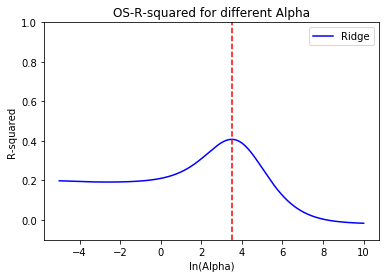

Optimal alpha for Ridge=33.1601924859, best OS R_2=0.408170339419


In [14]:
alphas = np.exp(np.linspace(-5,10,10000)) #exponential range of possible alphas
[alpha_optimal, best_R2, best_coefs]=Regularization_fit_alpha(1,dataTrain.iloc[:,1:],dataTrain.Y,dataValid.iloc[:,1:],dataValid.Y,alphas,Graph=True,logl=True)
print('Optimal alpha for Ridge={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))

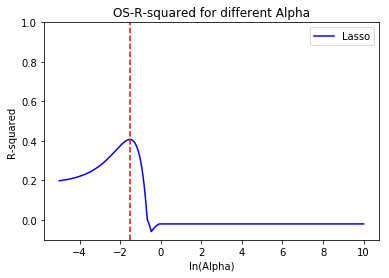

Optimal alpha for Lasso=0.218788019548, best OS R_2=0.407976931817


In [15]:
alphas = np.exp(np.linspace(-5,10,10000)) #exponential range of possible alphas
[alpha_optimal, best_R2, best_coefs]=Regularization_fit_alpha(2,dataTrain.iloc[:,1:],dataTrain.Y,dataValid.iloc[:,1:],dataValid.Y,alphas,Graph=True,logl=True)
print('Optimal alpha for Lasso={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))

In [16]:
#now consider the test sample performanc of the best Lasso model and its coefficients

In [17]:
Lasso=linear_model.Lasso(fit_intercept=True, alpha=alpha_optimal)

Lasso.fit(dataTrain.iloc[:,1:],dataTrain.Y)
# In sample:
YPred_IS=Lasso.predict(dataTrain.iloc[:,1:])
print("The IS R-squared of Lasso is: {0}".format(r2_score(dataTrain.Y,YPred_IS)))
#Out of sample
YPred_OS=Lasso.predict(dataTest.iloc[:,1:])
print("The OS R-squared of Lasso is: {0}".format(r2_score(dataTest.Y,YPred_OS)))
Lasso.coef_

The IS R-squared of Lasso is: 0.679858173615
The OS R-squared of Lasso is: 0.451936835654


array([0.        , 0.        , 0.        , 0.41519791, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.72985833, 0.68059909, 0.19852351, 0.        , 0.        ])

## Example 2. Recall the polynomial regression from previous class and try lasso for degree selection

In [18]:
#generate data and put it in the dataframe
np.random.seed(2018)
x=np.arange(-10,20,0.5)
y=x**4/100+x**3/20+x**2/3+2*x+np.random.normal(loc=0,scale=3,size=60)
data2=pd.DataFrame({'x':x,'y':y}) #create a dataframe
#slice the data in three pieces (we'll talk about those later)
data2.head() #for now let's stick with this first one

,x,y
0,-10.0,62.503031
1,-9.5,51.410761
2,-9.0,44.605198
3,-8.5,24.739247
4,-8.0,22.200164


In [19]:
data2 = data2.reindex(['y','x'], axis=1)

In [20]:
M=10
for p in range(1,M+1): #add more powers of x up to 10'th
    data2['x%d'%p]=data2.x**p
data2.head()

,y,x,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,62.503031,-10.0,-10.0,100.00,-1000.000,10000.0000,-100000.00000,1000000.000000,-1.000000e+07,1.000000e+08,-1.000000e+09,1.000000e+10
1,51.410761,-9.5,-9.5,90.25,-857.375,8145.0625,-77378.09375,735091.890625,-6.983373e+06,6.634204e+07,-6.302494e+08,5.987369e+09
2,44.605198,-9.0,-9.0,81.00,-729.000,6561.0000,-59049.00000,531441.000000,-4.782969e+06,4.304672e+07,-3.874205e+08,3.486784e+09
3,24.739247,-8.5,-8.5,72.25,-614.125,5220.0625,-44370.53125,377149.515625,-3.205771e+06,2.724905e+07,-2.316169e+08,1.968744e+09
4,22.200164,-8.0,-8.0,64.00,-512.000,4096.0000,-32768.00000,262144.000000,-2.097152e+06,1.677722e+07,-1.342177e+08,1.073742e+09


In [21]:
data2_Valid=data2.loc[40:49]
data2_Test=data2.loc[50:59]
data2_Train=data2.loc[0:39] 

In [22]:
import warnings
warnings.filterwarnings('ignore')

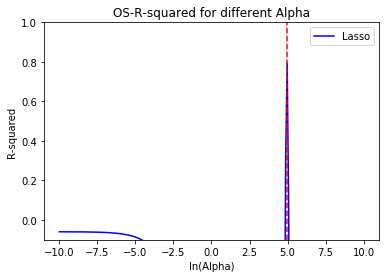

Optimal alpha for Lasso=144.730641765, best OS R_2=0.792822182006


array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  5.25976199e-02,
        1.68990266e-02,  1.60895306e-03,  3.53094156e-05, -2.17197707e-05,
       -1.22839950e-06,  6.85886212e-08,  4.65240523e-09])

In [23]:
alphas = np.exp(np.linspace(-10,10,200)) #exponential range of possible alphas
[alpha_optimal, best_R2, Lasso_coefs]=Regularization_fit_alpha(2,data2_Train.iloc[:,1:],data2_Train.y,data2_Valid.iloc[:,1:],data2_Valid.y,alphas,Graph=True,logl=True)
print('Optimal alpha for Lasso={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))
Lasso_coefs

In [24]:
#counter to our expectations the model eliminated lower powers, not the higher ones...

In [25]:
#what about test sample performance? not good despite good validation R2
Lasso=linear_model.Lasso(fit_intercept=True, alpha=alpha_optimal)

Lasso.fit(data2_Train.iloc[:,1:],data2_Train.y)
# In sample:
YPred_IS=Lasso.predict(data2_Train.iloc[:,1:])
print("The IS R-squared of Lasso is: {0}".format(r2_score(data2_Train.y,YPred_IS)))
#Out of sample
YPred_OS=Lasso.predict(data2_Test.iloc[:,1:])
print("The test R-squared of Lasso is: {0}".format(r2_score(data2_Test.y,YPred_OS)))
Lasso.coef_

The IS R-squared of Lasso is: 0.989554201993
The test R-squared of Lasso is: -733.386396016


array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  5.25976199e-02,
        1.68990266e-02,  1.60895306e-03,  3.53094156e-05, -2.17197707e-05,
       -1.22839950e-06,  6.85886212e-08,  4.65240523e-09])

The problem is the scale of the data! Regularization applies the same magnitude criteria to all the coefficients. While in case of the polynomial regression, regressors (powers of x) have totally different scale and so do the coefficients. What to do about it? 

#### We always need to bring regressors on the same scale (normalize) before applying regularization!!!

In [26]:
#learn standardization parameters from training set
mu=data2_Train.iloc[:,1:].mean()
sigma=data2_Train.iloc[:,1:].std()

In [27]:
#and apply standardization to all - training, validation and test 
#although sometimes done that way, strictly speaking it won't be appropriate to scale the entire dataset or
#scale validation and test directly;
#as scaling just like any other model should be trained over training only!
#besides we might want to have scaling model consistent over the entire dataset

In [28]:
data2_Train.iloc[:,1:]=(data2_Train.iloc[:,1:]-mu)/sigma

In [29]:
data2_Valid.iloc[:,1:]=(data2_Valid.iloc[:,1:]-mu)/sigma

In [30]:
data2_Test.iloc[:,1:]=(data2_Test.iloc[:,1:]-mu)/sigma

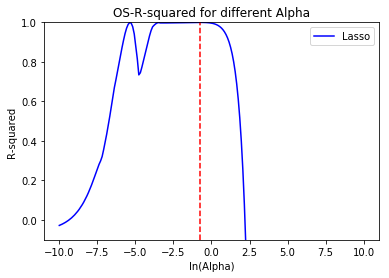

Optimal alpha for Lasso=0.470589627369, best OS R_2=0.999705724847


array([10.40647093,  0.        , 10.76712933, 19.86428381, 26.8587792 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ])

In [31]:
#now train Lasso and pick up the best alpha for it using the scaled data 
alphas = np.exp(np.linspace(-10,10,200)) #exponential range of possible alphas
[alpha_optimal, best_R2, Lasso_coefs]=Regularization_fit_alpha(2,data2_Train.iloc[:,1:],data2_Train.y,data2_Valid.iloc[:,1:],data2_Valid.y,alphas,Graph=True,logl=True)
print('Optimal alpha for Lasso={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))
Lasso_coefs

In [32]:
#so now the model looks about right

In [33]:
#what about test sample performance now? much better!
Lasso=linear_model.Lasso(fit_intercept=True, alpha=alpha_optimal)

Lasso.fit(data2_Train.iloc[:,1:],data2_Train.y)
# In sample:
YPred_IS=Lasso.predict(data2_Train.iloc[:,1:])
print("The IS R-squared of Lasso is: {0}".format(r2_score(data2_Train.y,YPred_IS)))
#Out of sample
YPred_OS=Lasso.predict(data2_Test.iloc[:,1:])
print("The test R-squared of Lasso is: {0}".format(r2_score(data2_Test.y,YPred_OS)))
Lasso.coef_

The IS R-squared of Lasso is: 0.996382740212
The test R-squared of Lasso is: 0.999954846764


array([10.40647093,  0.        , 10.76712933, 19.86428381, 26.8587792 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ])

## Task. Modeling median income with 311 patterns

### Load and curate 311 data

In [34]:
data311 = pd.read_csv( 'data/aggr311.csv' , index_col=0 )
data311.head()

,Zip,Complain,Count
1,NaN,Adopt-A-Basket,5
2,10001,Adopt-A-Basket,1
3,10003,Adopt-A-Basket,1
4,10009,Adopt-A-Basket,1
5,10010,Adopt-A-Basket,1


In [35]:
data311.Zip=pd.to_numeric(data311.Zip,errors='coerce')

In [36]:
data311=data311.loc[(data311.Zip>=10000)&(data311.Zip<11500)] #take only NYC zip codes

In [37]:
data311=pd.pivot_table(data311,index='Zip',columns='Complain',values='Count',fill_value=0)

In [38]:
data311.head()

Complain,APPLIANCE,Adopt-A-Basket,Air Quality,Animal Abuse,Animal Facility - No Permit,Animal in a Park,Asbestos,BEST/Site Safety,Beach/Pool/Sauna Complaint,Bike Rack Condition,...,Unsanitary Pigeon Condition,Urinating in Public,Vacant Lot,Vending,Violation of Park Rules,Water Conservation,Water Quality,Water System,Window Guard,X-Ray Machine/Equipment
Zip,,,,,,,,,,,,,,,,,,,,,
10000.0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,8,8,0,0,0,0,0
10001.0,0,1,90,0,0,1,20,36,1,1,...,3,0,2,51,5,5,2,366,0,0
10002.0,15,0,80,0,0,21,18,20,2,6,...,5,1,4,27,14,10,7,324,0,0
10003.0,15,1,143,0,2,44,24,13,2,2,...,7,11,2,54,25,12,5,318,0,0
10004.0,0,0,15,0,0,4,3,1,0,1,...,1,1,0,16,21,0,0,37,0,0


In [39]:
list_311=list(data311.columns)

In [40]:
list_311[0:10]

['APPLIANCE',
 'Adopt-A-Basket',
 'Air Quality',
 'Animal Abuse',
 'Animal Facility - No Permit',
 'Animal in a Park',
 'Asbestos',
 'BEST/Site Safety',
 'Beach/Pool/Sauna Complaint',
 'Bike Rack Condition']

In [41]:
len(data311)

264

In [42]:
Total311=data311.sum(axis=1) #total 311 activity per zip code
data311=data311.div(data311.sum(axis=1), axis=0) #normalize activity of various cathegories within zip code by total
data311=data311.loc[Total311>100] #keep only those zip codes having sufficient activity

In [43]:
len(data311) #only 179 zip codes with reliable data left

179

In [44]:
data311.head()

Complain,APPLIANCE,Adopt-A-Basket,Air Quality,Animal Abuse,Animal Facility - No Permit,Animal in a Park,Asbestos,BEST/Site Safety,Beach/Pool/Sauna Complaint,Bike Rack Condition,...,Unsanitary Pigeon Condition,Urinating in Public,Vacant Lot,Vending,Violation of Park Rules,Water Conservation,Water Quality,Water System,Window Guard,X-Ray Machine/Equipment
Zip,,,,,,,,,,,,,,,,,,,,,
10000.0,0.000000,0.000000,0.008772,0.0,0.000000,0.008772,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.070175,0.070175,0.000000,0.000000,0.000000,0.0,0.0
10001.0,0.000000,0.000146,0.013179,0.0,0.000000,0.000146,0.002929,0.005272,0.000146,0.000146,...,0.000439,0.000000,0.000293,0.007468,0.000732,0.000732,0.000293,0.053595,0.0,0.0
10002.0,0.001330,0.000000,0.007095,0.0,0.000000,0.001862,0.001596,0.001774,0.000177,0.000532,...,0.000443,0.000089,0.000355,0.002394,0.001242,0.000887,0.000621,0.028734,0.0,0.0
10003.0,0.001331,0.000089,0.012690,0.0,0.000177,0.003905,0.002130,0.001154,0.000177,0.000177,...,0.000621,0.000976,0.000177,0.004792,0.002218,0.001065,0.000444,0.028219,0.0,0.0
10004.0,0.000000,0.000000,0.009740,0.0,0.000000,0.002597,0.001948,0.000649,0.000000,0.000649,...,0.000649,0.000649,0.000000,0.010390,0.013636,0.000000,0.000000,0.024026,0.0,0.0


In [45]:
#load the data
dataIncome=pd.read_csv("data/MeanZip.csv",index_col=0)
dataIncome=dataIncome.apply(pd.to_numeric, errors='coerce')
dataIncome=dataIncome.loc[dataIncome.Mean>0]
dataIncome.head()

,Median,Mean,Pop
Zip,,,
1001,56662.5735,66687.7509,16445
1002,49853.4177,75062.6343,28069
1003,28462.0000,35121.0000,8491
1005,75423.0000,82442.0000,4798
1007,79076.3540,85801.9750,12962


In [46]:
#merge income data with 311
DataIncome1=dataIncome.merge(data311,left_index=True,right_index=True)

In [47]:
DataIncome1.head()

,Median,Mean,Pop,APPLIANCE,Adopt-A-Basket,Air Quality,Animal Abuse,Animal Facility - No Permit,Animal in a Park,Asbestos,...,Unsanitary Pigeon Condition,Urinating in Public,Vacant Lot,Vending,Violation of Park Rules,Water Conservation,Water Quality,Water System,Window Guard,X-Ray Machine/Equipment
Zip,,,,,,,,,,,,,,,,,,,,,
10001.0,71244.6100,123112.7764,17678,0.000000,0.000146,0.013179,0.0,0.000000,0.000146,0.002929,...,0.000439,0.000000,0.000293,0.007468,0.000732,0.000732,0.000293,0.053595,0.0,0.0
10002.0,30843.9574,46258.6118,70878,0.001330,0.000000,0.007095,0.0,0.000000,0.001862,0.001596,...,0.000443,0.000089,0.000355,0.002394,0.001242,0.000887,0.000621,0.028734,0.0,0.0
10003.0,89998.5339,139330.9968,53609,0.001331,0.000089,0.012690,0.0,0.000177,0.003905,0.002130,...,0.000621,0.000976,0.000177,0.004792,0.002218,0.001065,0.000444,0.028219,0.0,0.0
10004.0,110183.6857,156682.7615,1271,0.000000,0.000000,0.009740,0.0,0.000000,0.002597,0.001948,...,0.000649,0.000649,0.000000,0.010390,0.013636,0.000000,0.000000,0.024026,0.0,0.0
10005.0,115133.2855,163762.6601,1517,0.000000,0.000000,0.008219,0.0,0.000000,0.002192,0.000548,...,0.000000,0.000000,0.000000,0.013699,0.000000,0.000548,0.000000,0.019726,0.0,0.0


#### Q1. Run the regression of Median Income agains all the 311 components

#### Q2. Split the data randomly into training (50%), validation (25%) and test (25%). Evaluate peformance of the linear model over the test sample

#### Q3. Now try Lasso regression, training over training and evaluating it over test set and manually tune the parameter

#### Q4. Finally find the optimal parameter over the validation set and evaluate over test

# Dimensionality reduction

In general a multi-variate regression model (not necessarily linear) could be expressed as looking for a functional dependence 
$$
y=f(x)
$$
between an output variable $y$ and the multi-dimensional vector of input variables (features, regressors) $x=(x_1,x_2,x_3,....,x_n)$.

When the dimensionality $n$ of the feature space (number of regressors) is too high with respect to the number of observations, it may cause multiple issues:

- complexity: the model involving multiple regressors becomes difficult to fit and interpret;

- multicollinearity: a large set of regressors could encounter substantial correlations, leading to multicollinearity of regressors and high variance in their estimates, making coefficients hard to interpret/rely on;

- overfitting: as multiple regressors might contain a lot of relevant but also irrelevant information, the model could pick it up, becoming too specifically adjusted to the training set, which would reduce its generalizeability (performance over the validation/test set);

In addition, exploratory analysis, including visualization of multi-dimensional data is much more difficult. Imagine we want to visualize complaining profiles of NYC neighborhoods? As each profile is characterized with a 162-dimensional vector, how to perform such a visualization? Would not it be more convenient to find a 2D or 3D visual representation instead?

Reducing complexity of the model and its data (number of features or their dimensionality) is usually recommended in such cases. The most streighforward way of doing so is through feature selection. 

Feature selection aims to reduce dimensionality of $x$ by removing some of its components $x_j$ which turn out to be the least relevant for the model, i.e. have the lowest positive or even negative impact on the model performance over the external validation set. This way feature selection provides a mapping of vectors $x$ into a shorter vector of its subcomponents, e.g.
$$
(x_1,x_2,x_3,x_4,x_5)\to (x_1,x_3,x_5).
$$

But feature selection is often too rigid - we have to make our choices of keeping or getting rid of each variable entirely, though it might be the case that each regressor by itself still contains certain valuable information, but all together the feature space is redundant. As an alternative one can think of expressing the useful information contained in a large inital amount of regressors through some smaller amount of latent variables (different from the initial regressors) able to explain all or almost all the relevant information. This is called dimensionality reduction.

In general, dimensionality reduction looks for an arbitrary mapping of the feature space (possibly transforming the features not just removing some) into a new feature space of a smaller dimension:
$$
x=(x_1,x_2,x_3....,x_n)\to x'=(x_1',x_2',x_3',....,x_m),
$$
so that a simpler model $y=f(x')$ could be learned instead.

E.g. a mapping
$$
(x_1,x_2,x_3,x_4,x_5)\to x'=(x_1+x_2+x_3+x_4+x_5,x_1 x_2 x_3 x_4 x_5)
$$
could serve as an example of reducing the dimensionality of the feature space from $5$ to $2$.

Such reduction often turnes out to be pretty useful as learning a model over a smaller set of features could be easier and such models might be more resilient to overfitting and easier to interpret. Often dimensionality could be substantially reduced without reducing the capacity of the model to fit the output variable much. This is becasue the Pareto rule is perfectly applicable in this scenario - 80% (or even 90, 95, 99%) of the useful information contained in the original regressors could be effectively packed into a much smaller amount of the new regressors (under a suitable transformation), often being 20% (or even 10, 5, 1%) of the original size. This way 80% (or even 90, 95, 99%) of the efficieny could be acheived with 20% (or even 10, 5, 1%) of the effort (complexity).

# Problem example

Model economic characteristics of urban neighborhoods (zip code areas), such as  
**income, unemployment or average real estate prices using the structure of 311 complains**  
as a signature of social activity.

[Wang L, Qian C, Kats P, Kontokosta C, Sobolevsky, S. (2017) Structure of 311
service requests as a signature of urban location. PloS ONE. 12(10), e0186314.]

<img src="data/fig5.png">

<img src="data/fig2.png">

We saw that complaining patterns cluster in space but are pretty different for different urban neighborhoods. While the clusters with distinctive complaining profiles are also distinctive in terms of demography and economic background.

**What is we use the relative frequency of each of the 162 categories of complains as features to model target economic indicators accross NYC zip code areas?**

What issues such a model might face?

#### 311 service requests data.
https://en.wikipedia.org/wiki/3-1-1

3-1-1 is a special telephone number supported in many communities in Canada and the United States. The number provides access to non-emergency municipal services. The number format follows the N11 code for a group of short, special-purpose local numbers as designated in the North American Numbering Plan.
The number 3-1-1 is intended in part to divert routine inquiries and non-urgent community concerns from the 9-1-1 number which is reserved for emergency service. A promotional website for 3-1-1 in Akron described the distinction as follows: "Burning building? Call 9-1-1. Burning Question? Call 3-1-1."

But first let's ask a simpler question - **how can we visualize urban neighborhoods according to the structure of their 311 service requests**?

And can we recognize different boroughs in this visualization?

So how do we visualize 162 dimensional data for each of the approximately 264 zip codes?

In [48]:
# create borough labels 
Z=np.array(data311.index)
manhattanInd=(Z>10000)&(Z<10300) #Manhattan
statenInd=(Z>=10300)&(Z<10400) #Staten Island
brooklynInd=(Z>=11000)&(Z<11300) #Brooklyn
queensInd=(Z>=11300)&(Z<11500) #Queens
bronxInd=(Z>=10400)&(Z<10500) #Bronx
#create an array of the same length as data311 index providing the borough number
D=Z*0
D[manhattanInd]=1
D[statenInd]=2
D[brooklynInd]=3
D[queensInd]=4
D[bronxInd]=5

Try visualizing the data based on some two types of complaints

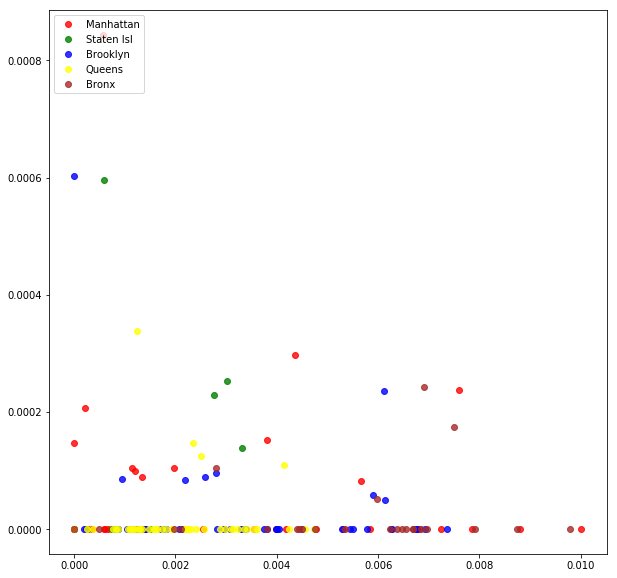

In [49]:
colors=('gray','red','green','blue','yellow','brown')
fig = plt.figure(figsize=(10,10))
for d in range(1,6):
    plt.plot(np.array(data311.iloc[D==d,0]), np.array(data311.iloc[D==d,1]),
        'o', color=colors[d], alpha=0.8, label=d)
plt.legend(['Manhattan','Staten Isl','Brooklyn','Queens','Bronx'],loc='upper left')

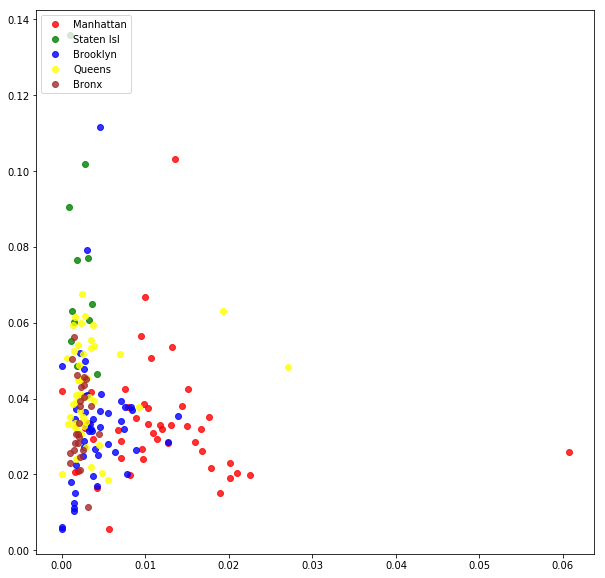

In [50]:
colors=('gray','red','green','blue','yellow','brown')
fig = plt.figure(figsize=(10,10))
for d in range(1,6):
    plt.plot(np.array(data311.loc[D==d,'Air Quality']), np.array(data311.loc[D==d,'Water System']),
        'o', color=colors[d], alpha=0.8, label=d)
plt.legend(['Manhattan','Staten Isl','Brooklyn','Queens','Bronx'],loc='upper left')

#### So is it possible to find a smaller number of parameters to adequately represent high dimensional data?

### Example 1. Toy data

In [51]:
#generate a random sample of houses with "Size" and "Price" being function of it
np.random.seed(1)
N=100
S=np.random.randint(1000,10000, size=N)
P=S*300+50000
data1 = pd.DataFrame({'S':S,'P':P})
data1.head()

,P,S
0,420500,1235
1,1907600,6192
2,621500,1905
3,2693900,8813
4,1218500,3895


Text(0,0.5,'P')

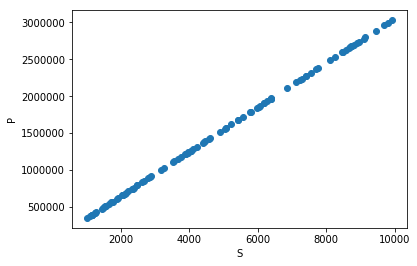

In [52]:
#visualize the data
plt.plot(data1.S, data1.P, 'o')
plt.xlabel('S')
plt.ylabel('P')

In [53]:
#all the data points lay on a single line and one can represent all the information by a single-dimensional 
# position coordinate on this line

Text(0,0.5,'P')

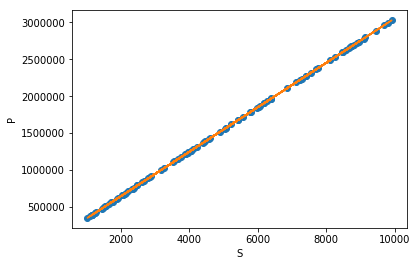

In [54]:
plt.plot(data1.S, data1.P, 'o')
plt.plot(data1.S, data1.P)
plt.xlabel('S')
plt.ylabel('P')

In [55]:
#what if the data is a little more complicated
P=S*300+50000+np.random.normal(0,100000,size=N)
data2 = pd.DataFrame({'S':S,'P':P})
data2.head()

,P,S
0,6.390575e+05,1235
1,1.767950e+06,6192
2,4.770886e+05,1905
3,2.643453e+06,8813
4,1.234504e+06,3895


Text(0,0.5,'P')

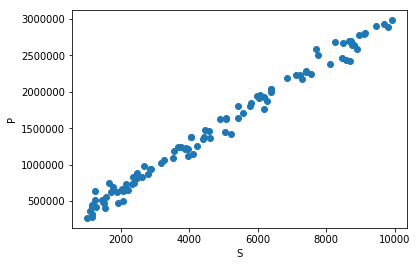

In [56]:
#visualize the data
plt.plot(data2.S, data2.P, 'o')
plt.xlabel('S')
plt.ylabel('P')

In [57]:
#there is high correlation in data
data2.corr()

,P,S
P,1.0000,0.9942
S,0.9942,1.0000


In [58]:
#standardize the data
data2S=(data2-data2.mean())/data2.std()

Text(0,0.5,'P')

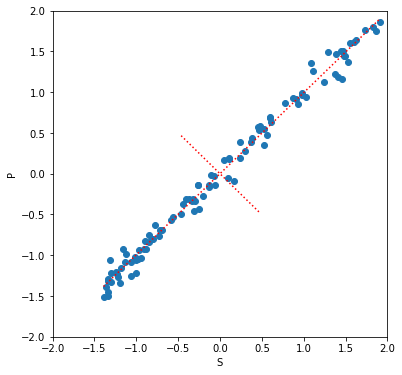

In [59]:
#The data is still largely around one major line
#but there is also some fluctuation in the orthogonal dymension
plt.figure(figsize=(6,6))
plt.plot(data2S.S, data2S.P, 'o')
x=data2S.S.sort_values()
plt.plot(x, x*np.corrcoef(data2S.S,data2S.P)[0,1],':r')
x=data2S.S[abs(data2S.S)<0.5].sort_values()
plt.plot(x, -x/np.corrcoef(data2S.S,data2S.P)[0,1],':r')
plt.xlim((-2,2)); plt.ylim((-2,2));
plt.xlabel('S')
plt.ylabel('P')

Those two dashed lines form axis of a new coordinate system in which the first coordiate largely represents the data, while second containts some residual variation. Note that the first axis is picked in such a way that **variance of the data along it is maximized**

How to convert them to uncorrelated features $p_1$,$p_2$ (principal components) using some linear transform 
$$
P=XV?
$$ 

$P$ is a matrix of two columns $p_1$,$p_2$, while $V$ is a $2x2$ conversion matrix.

This transform will effectively rotate the image above to get a cloud with approximate axial symmetry. Or we can think of it as selecting different coordinate axis, so that X being projected on them (represented in a new system of coordinates) is expressed by $P$.

In [60]:
#find eigenvectors of X'X
XS=np.array(data2S)
XC=np.dot(XS.transpose(),XS)
eigvalues, eigvectors = np.linalg.eig(XC)
print 'Eigenvalues=',eigvalues
print 'Eigenvectors=\n',eigvectors

Eigenvalues= [197.42576011   0.57423989]
Eigenvectors=
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]


In [61]:
#make sure eigenvalues are sorted and form the matrix of eigenvectors
idx = eigvalues.argsort()[::-1]   
eigvalues = eigvalues[idx]
eigvectors = eigvectors[:,idx]
V = eigvectors
V

array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]])

In [62]:
#perform the transformation computing new coordinates for the data in the new coordinate system (principal components)
P=np.dot(XS,V)

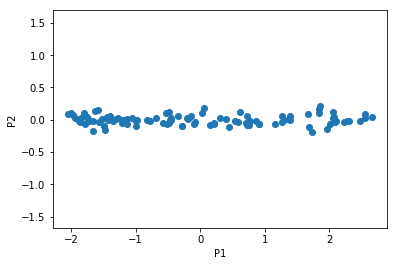

In [63]:
#visualize PCs
plt.plot(P[:,0],P[:,1], 'o')
plt.xlabel('P1')
plt.ylabel('P2')
plt.axis('equal'); #enforce same scale for axes

In [64]:
#check there is no correlation now
np.corrcoef(P[:,0],P[:,1])

array([[1.00000000e+00, 2.33586986e-15],
       [2.33586986e-15, 1.00000000e+00]])

# Principle component analysis

A most common linear approach to dimentionality reduction is the principal component analysis. An idea is that given $N$ observations for the $n$ regressors $x_j$

$$
X=\{x_i^j, i=1..n, j=1..N\}
$$

we try to come up with a linear transformation

$$
U=X V,
$$

where $V$ is $nxp$-dimensional transformation matrix and $U$ is a $N x p$ matrix of new factors $u_1,u_2,...,u_p$ (columns of $U$), such that they explain as much of initial information contained in $X$ as possible for the $p$ latent variables - linear combinations of the original ones.

## Technique

Before applying PCA variables $x_i$ are usually centered ($E[x_i]=0$) and sometimes also normalized ($var[x_i]=1$).

**Selecting first principle component**: look for the column unit basis $N x 1$ vector of weights/loadings $v_1$, such that resulting variable 
$$
u_1=X v_1
$$ 
has maximal possible variance 
$$
var[u_1]\to\max
$$
(captures as much information/distinctions from the complete feature space $X$)

So we maximize
$$
var[u_1]=(X v_1)^T X v_1=v_1^T X^T X v_1\to \max
$$
or
$$
v_1=argmax_{v_1: v_1^T v_1=1}var[u_1] =argmax_{v_1: v_1^T v_1=1}u_1^T u_1=argmax_{v_1: v_1^T v_1=1}v_1^T X^T X v_1.
$$

Then after first basis vector $v_1$ and principle component $u_1$ are selected, the second basis vector $v_2$ is selected following the same principle, but with an additional constrain of being orthogonal to $v_1$. 

Similarly each following $i$-th vector $v_i$ is being defined as
$$
v_i=argmax_{v_i: v_i^T v_i=1, v_i^T v_j=0, j<i}v_i^T X^T X v_i.
$$

The problem is easy to solve knowing the eigenvectors of $X^T X$, i.e. such unit vectors $v_i$ ($v_i^T v_i=1$) that

$$
\lambda_i v_i=X^T X v_i
$$

So for such eigenvectors vectors $v_i$
$$
var[u_i]=v_i^T X^T X v_i = \lambda_i v_i^T v_i = \lambda_i.
$$

This way one can also see that all the eigenvalues of $X^T X$ are positive.

*And out of them the best choice for $v_1$ is the leading eigenvector with the highest eigenvalue.*

**Now consider an arbitrary vector $w$** - not necessarily an eigenvector. If we know $n$ unit eigenvectors with distinct eigenvalues such that $\lambda_1>\lambda_2> ...>\lambda_n>0$, they produce an orthogonal basis in the $n$-dimensional space and for any unit vector $w=e_1 v_1+e_2 v_2+... +e_n v_n$, provided $\sum_i e_i^2=1$, we can see that

$$
w^T X^T X w=\lambda_1 e_1^2+\lambda_2 e_2^2+...+\lambda_n e_n^2,
$$

which is maximized for $e_1=1, e_2=e_3=...e_n=0$ (as $\sum_i e_i^2=1$), *i.e. $w=v_1$*. 

Similarly the second, third, etc loading vectors could be found as $v_2,v_3,...$ correspondingly.

*So the transformation matrix $V$ is composed by the columns being eigenvectors of $X^T X$ and the variance of the data along each of the new axis equals to the value of the corresponding eigenvalue $\lambda_1>\lambda_2> ...>\lambda_n>0$.*

**In the matrix form**

$$
diag(\lambda)V=X^T X V
$$

where $\lambda_i$ are the corresponding eigenvalues (mutually distinctive). First of all its easy to see that such vectors $v_i$ are always mutually orthogonal, as

$$
v_j^T v_i= v_j^T X^T X v_i/\lambda_i =(X^T X w_j)^T v_i/\lambda_i=v_j^T v_i \lambda_j/\lambda_i.
$$

This is why $V^T V=I_n$.

Also the solution follows from the singular value decomposition of the matrix $X$:

$$
X=W \Sigma V^T,
$$

where $W$ is a $N x n$ matrix of mutually orthogonal unit columns, $V$ is a $n x n$ matrix of mutually orthogonal unit columns and $\Sigma$ is an $n x n$- diagonal matrix, i.e.

$$
W^T W=V^T V=I_n
$$

Then

$$
X^T X=V\Sigma W^T W \Sigma V^T=V\Sigma^2 V^T
$$

and its easy to see that $V$ is the matrix of eigenvectors and $\Sigma$ is the diagonal matrix of square roots of eigenvalues. Then 

$$
U=XV=W\Sigma V^T V=W\Sigma.
$$

## PCA as a dimensionality reduction tool

Now once matrixes $V, U, \Sigma$ are defined as well as the eigenvalues $\lambda_j$ (being the squares of the diagonal elements of $\Sigma$), how do we use that for dimensionality reduction? 

Matrix $V$ performs a transformation of the regressors $x_i$ to the new orthogonal variables $u_i$ being the columns of $U=XV$. And 
$$
Var[u_i]=\lambda_i
$$

This is interpreted as each variable $u_i$ containing the fraction $\lambda_i/\sum\limits_j \lambda_j$ of the entire information (variation) contained in all the regressors. And the choice of regressors $u_i$ is such that $\lambda_1,\lambda_2,...$ are sequentially maximized. So if one wants to select as few latent variables as possible in order to cover a given franction $\alpha$ (often $95\%$) of information (variation) from it is enough to select first $k$ principle components $u_1,u_2,...u_k$, so that 

$$
\frac{\sum\limits_{i=1}^k\lambda_i}{\sum\limits_{i=1}^n\lambda_i}\geq \alpha.
$$

## PCA over the features space for dimensionality reduction in the linear regression

The leading principle components contain most of the information from the entire original feature space, and might be suitable to represent the feature space reducing its dimensionality. This however does not guarantee (although usually provides a good chance) that those leading components are indeed the ones most relevant for modeling the output variables, so reducing dimensionality of the regression model by selecting the leading principle components does not always lead to the best outcome. 

In this case, using regular feature selection (e.g. backward step-wise or forward step-wise) could be the best. PCA however will help by ensuring that the features are not interrelated and can be effectively excluded or included one-by-one. This way feature selection after PCA is always more efficient than the feature selection over the original non-transformed feature space. 

This also makes it more reasible (although still not entirely) to rely on the "naive" feature selection based on p-values. While p-values still represent an intrinsic property of the training set, and this way can not guarantee generalizeability, since the standardized principle components are non-correlated/othogonal, a low p-value is a good indicator of the regressor's utility as long as the size/choice of the training data is sufficient to exclude random coincidences.

The most significant downside of using PCA for feature selection is that the remaining selected principle components could be pretty hard to interpret as they often look like arbitrary linear combinations of multiple features.




## Task 1. Apply PCA to 311 data
- Visualize the explained variance as the function of the number of leading components
- Plot zip codes (as dots) represented by their first and second principal components and colored according to their borough; can you distinguish boroughs based on 311 PCs?

In [65]:
scaler311 = preprocessing.StandardScaler().fit(data311)
data311S=scaler311.transform(data311)  

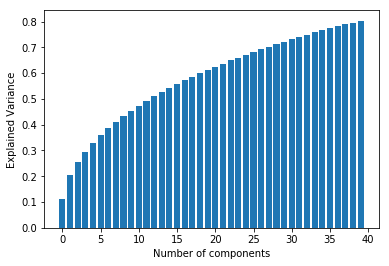

In [66]:
#perform PC decomposition over data311
pca = PCA(data311S.shape[1])
data311P=pca.fit_transform(data311S)
eigenvalues = pca.explained_variance_ratio_
#plot explained variance over the number of compinents
n=40
plt.bar(np.arange(n), eigenvalues[:n].cumsum())
plt.xlabel("Number of components")
plt.ylabel("Explained Variance")
plt.show()

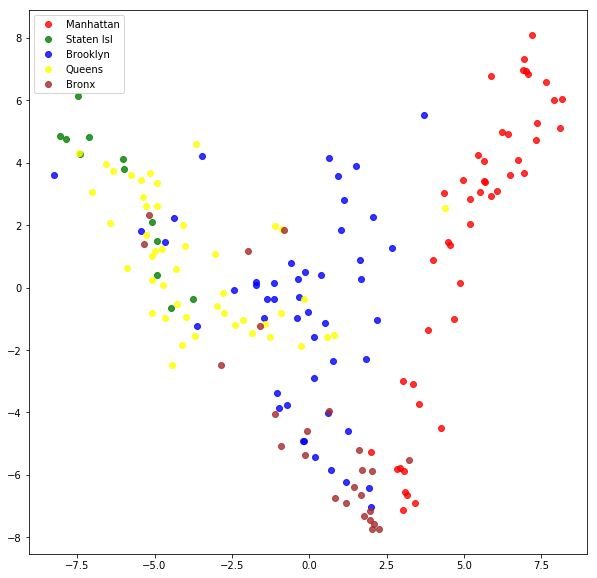

In [67]:
#2-d plot
colors=('gray','red','green','blue','yellow','brown')
fig = plt.figure(figsize=(10,10))
for d in range(1,6):
    plt.plot(np.array(data311P[D==d,0]), np.array(data311P[D==d,1]),
        'o', color=colors[d], alpha=0.8, label=d)
plt.legend(['Manhattan','Staten Isl','Brooklyn','Queens','Bronx'],loc='upper left')